In [ ]:
%load_ext tensorboard
%tensorflow_version 2.x
!rm -rf ./logs/ 

In [ ]:
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np

batch_size = 50
num_classes = 10
epochs = 30
num_train_samples = 1000

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


60000 train samples


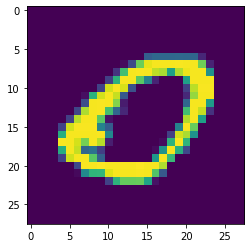

In [ ]:
def rotate_image(images, degrees):
    rot_images = []
    for image in images:
        ##img_rot = ndimage.rotate(image, degrees, reshape=False)
        img_rot = 255 - image
        rot_images.append(img_rot.reshape(28, 28))
    return np.array(rot_images)

# applying transformation to image
plt.imshow(x_train[1].reshape(28, 28))
img_rot = ndimage.rotate(x_train[1], 90, reshape=False)
img_rot = np.flipud(img_rot)
plt.imshow(img_rot.reshape(28, 28))

x_train_rot = rotate_image(x_train, 90)
x_test_rot = rotate_image(x_test, 90)
    
print(x_train_rot.shape[0], 'train samples')

def reshapeImages(images):
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    images = images.astype('float32')
    images /= 255
    print(images.shape[0], 'samples')
    return (images)

def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()
    
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('#f Iterations')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
x_val = reshapeImages(x_train)[-5000:]
x_train = reshapeImages(x_train)[:num_train_samples]
x_test = reshapeImages(x_test)
x_val_rot = reshapeImages(x_train_rot)[-5000:]
x_train_rot = reshapeImages(x_train_rot)[:num_train_samples]
x_test_rot = reshapeImages(x_test_rot)

# convert class vectors to binary class matrices
y_val = keras.utils.to_categorical(y_train, num_classes)[-5000:]
y_train = keras.utils.to_categorical(y_train, num_classes)[:num_train_samples]
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 samples
60000 samples
10000 samples
60000 samples
60000 samples
10000 samples


In [ ]:
x_train.shape

(1000, 784)

In [ ]:
## first model (training of whole model)
input1 = keras.layers.Input(shape=(784, ))
dense1 = keras.layers.Dense(128, activation='relu')(input1)
dense2 = keras.layers.Dense(128, activation='relu')(dense1)
dense3 = keras.layers.Dense(20, activation='relu')(dense2)
output = keras.layers.Dense(num_classes, activation='softmax')(dense3)

model = keras.Model(inputs=input1, outputs=[output])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 119,782
Trainable params: 119,782
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(np.concatenate((x_train, x_train_rot)), np.concatenate((y_train, y_train)),
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,
                    shuffle = True,
                    validation_data=(np.concatenate((x_val, x_val_rot)), np.concatenate((y_val, y_val))))
score = model.evaluate(np.concatenate((x_test, x_test_rot)), np.concatenate((y_test, y_test)), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
40/40 [==============================] - 1s 14ms/step - loss: 2.1158 - accuracy: 0.2705 - val_loss: 1.8237 - val_accuracy: 0.4009
Epoch 2/30
40/40 [==============================] - 0s 10ms/step - loss: 1.4976 - accuracy: 0.5075 - val_loss: 1.3537 - val_accuracy: 0.5376
Epoch 3/30
40/40 [==============================] - 0s 11ms/step - loss: 1.1834 - accuracy: 0.5850 - val_loss: 1.2012 - val_accuracy: 0.6044
Epoch 4/30
40/40 [==============================] - 0s 10ms/step - loss: 1.0329 - accuracy: 0.6455 - val_loss: 1.0144 - val_accuracy: 0.6498
Epoch 5/30
40/40 [==============================] - 0s 11ms/step - loss: 0.8529 - accuracy: 0.7150 - val_loss: 0.8821 - val_accuracy: 0.7177
Epoch 6/30
40/40 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.7850 - val_loss: 0.8234 - val_accuracy: 0.7367
Epoch 7/30
40/40 [==============================] - 0s 11ms/step - loss: 0.5918 - accuracy: 0.8120 - val_loss: 0.6866 - val_accuracy: 0.7885
Epoch 8/30
40

In [ ]:
## Retrain model on origin of data set (rotated or not rotated) and try to predict it

model_set = keras.models.clone_model(model)
model_set.set_weights(model.get_weights()) 
model_set._layers.pop()
for layer in model_set.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_set.layers[-1].output
outputSet = keras.layers.Dense(2, activation="softmax", name="outputSet")(last)
model_set = keras.models.Model(model_set.input, outputSet)

for layer in model_set.layers:
    print(layer, layer.trainable)
    
model_set.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_set.summary()

y_train_not_rotated = np.ones(num_train_samples)
y_train_rotated = np.zeros(num_train_samples)

y_test_not_rotated = np.ones(10000)
y_test_rotated = np.zeros(10000)

y_train_set = keras.utils.to_categorical(np.concatenate((y_train_not_rotated,y_train_rotated)), 2)
y_test_set = keras.utils.to_categorical(np.concatenate((y_test_not_rotated,y_test_rotated)), 2)

history = model_set.fit(np.concatenate((x_train, x_train_rot)), y_train_set,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=((np.concatenate((x_test, x_test_rot)), y_test_set)))
score = model_set.evaluate(np.concatenate((x_test, x_test_rot)), y_test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f63d0088320> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f63dc1fba58> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f63d0041b00> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f63d0041a90> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f63d0041160> True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
___

In [ ]:
## Retrain model on origin of data set (rotated or not rotated) and on the MNIST digits.
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights()) 
model_new._layers.pop()
for layer in model_new.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_new.layers[-1].output
outputSet = keras.layers.Dense(2, activation="softmax", name="outputSet")(last)
outputNrs = keras.layers.Dense(num_classes, activation="softmax", name="outputNrs")(last)
model_new = keras.models.Model(model_new.input, [outputNrs, outputSet])

for layer in model_new.layers:
    print(layer, layer.trainable)
    
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics={"outputSet":'accuracy', "outputNrs":'accuracy'})

model_new.summary()

y_train_not_rotated = np.ones(num_train_samples)
y_train_rotated = np.zeros(num_train_samples)

y_test_not_rotated = np.ones(10000)
y_test_rotated = np.zeros(10000)

y_train_set = keras.utils.to_categorical(np.concatenate((y_train_not_rotated,y_train_rotated)), 2)
y_test_set = keras.utils.to_categorical(np.concatenate((y_test_not_rotated,y_test_rotated)), 2)

history = model_new.fit(np.concatenate((x_train, x_train_rot)), [np.concatenate((y_train, y_train)),y_train_set],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(np.concatenate((x_test, x_test_rot)), [np.concatenate((y_test, y_test)),y_test_set]))
score = model_new.evaluate(np.concatenate((x_test, x_test_rot)), [np.concatenate((y_test, y_test)),y_test_set], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f636eacde80> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f636eacd128> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f636eacd5f8> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f636eacdac8> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f636e93a6d8> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f636e99a320> True
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      input_1[0][0]                    
____________________________

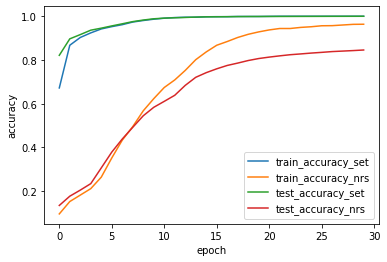

In [ ]:
plt.plot(history.history['outputSet_accuracy'])
plt.plot(history.history['outputNrs_accuracy'])
plt.plot(history.history['val_outputSet_accuracy'])
plt.plot(history.history['val_outputNrs_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'train_accuracy_set','train_accuracy_nrs','test_accuracy_set','test_accuracy_nrs'], loc='best')
plt.show()


In [ ]:
## Calculate confusion matrix for baseline model
model_ = keras.models.clone_model(model)
model_.set_weights(model.get_weights()) 

model_._layers.pop()
for layer in model_.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_.layers[-1].output
output = keras.layers.Dense(num_classes, activation="softmax", name="output")(last)
model_ = keras.models.Model(model_.input, output)

for layer in model_.layers:
    print(layer, layer.trainable)
    
model_.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics={"output":'accuracy'})

model_.summary()

history = model_.fit(np.concatenate((x_train, x_train_rot)), np.concatenate((y_train, y_train)),epochs=20,
    shuffle=True,
    verbose=1)


y_pred = model_.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred_rot = model_.predict(x_test_rot)
y_pred_rot = np.argmax(y_pred_rot, axis=1)

y_test_binary = np.argmax(y_test, axis=1)
y_test_rot_binary = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_binary, y_pred)
cnf_matrix_rot = confusion_matrix(y_test_rot_binary, y_pred_rot)

fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
tp = np.diag(cnf_matrix)
tn = cnf_matrix.sum() - (fp + fn + tp)

fp_rot = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix_rot)  
fn_rot = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix_rot)
tp_rot = np.diag(cnf_matrix_rot)
tn_rot = cnf_matrix_rot.sum() - (fp_rot + fn_rot + tp_rot)

## female
prob_true_beutel = (tp + fp)/y_test.shape[0]
print("prob_1 (beutel):", prob_true_beutel)
acc = (tp + tn)/y_test.shape[0]
print("acc:", acc)
tpr = tp/(tp + fn)
print("tpr:",tpr)
ppv = tp/(tp + fp)
print("ppv:",ppv)
tnr = tn/(tn + fp)
print("tnr:",tnr)

print("---------------------------------------------------")
## male
prob_true_beutel_rot = (tp_rot + fp_rot)/y_test.shape[0]
print("prob_1 rot (beutel):", prob_true_beutel_rot)
acc_rot = (tp_rot + tn_rot)/y_test.shape[0]
print("acc rot:", acc_rot)
tpr_rot = tp_rot/(tp_rot + fn_rot)
print("tpr rot:", tpr_rot)
ppv_rot = tp_rot/(tp_rot + fp_rot)
print("ppv rot:",ppv_rot)
tnr_rot = tn_rot/(tn_rot + fp_rot)
print("tnr rot:",tnr_rot)
print("---------------------------------------------------")

parity_gap_beutel = abs(prob_true_beutel - prob_true_beutel_rot)
pred_parity = abs(ppv_rot - ppv_rot)
equal_opportunity = abs(tpr - tpr_rot) ## = equality_gap_1
equality_gap_0_beutel = abs(tnr - tnr_rot)
accuracy_gap = abs(acc - acc_rot)

print("parity gap (beutel):", parity_gap_beutel)
print("predictive parity:", pred_parity)
print("equal opportunity (equality gap 1 (beutel)):", equal_opportunity)
print("equality gap 0 (beutel):", equality_gap_0_beutel)
print("accuracy gap:", accuracy_gap)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0e0773c278> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0e0773c940> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0e0773c780> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0e0773c0b8> False
<tensorflow.python.keras.layers.core.Dense object at 0x7f0e07a51518> True
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
___

In [ ]:
## Prepare dataset to get weights for specific digits of MNIST
numberToLookAt = 9
keepIndeces_train = np.where((np.argmax(y_train, axis = 1) == numberToLookAt))[0]
y_train_new = np.zeros([y_train.shape[0], 2])
for i in range(1, y_train.shape[0]):
  if i in keepIndeces_train:
    y_train_new[i] = [1, 0]

keepIndeces_test = np.where((np.argmax(y_test, axis = 1) == numberToLookAt))[0]
y_test_new = np.zeros([y_test.shape[0], 2])
for i in range(1, y_test.shape[0]):
  if i in keepIndeces_test:
    y_test_new[i] = [1, 0]

In [ ]:
intermediate_layer_model = keras.models.Model(inputs=model.input,
                                 outputs=model.get_layer("dense_2").output)

rep_layer = intermediate_layer_model.predict(x_train)
rep_layer_rot = intermediate_layer_model.predict(x_train_rot)

rep_train_x = np.concatenate((rep_layer, rep_layer_rot))
train_y = np.concatenate((y_train_new, y_train_new))

train_sens = np.zeros((rep_layer.shape[0],1))
rot_train_sens = np.ones((rep_layer_rot.shape[0],1))

train_sens_ = np.concatenate((train_sens, rot_train_sens))
rep_layer_test = intermediate_layer_model.predict(x_test)
rep_layer_rot_test = intermediate_layer_model.predict(x_test_rot)

rep_test_x = np.concatenate((rep_layer_rot_test, rep_layer_test))
test_y = np.concatenate((y_test_new, y_test_new))

test_sens = np.zeros((rep_layer_rot_test.shape[0],1))
rot_test_sens = np.ones((rep_layer_test.shape[0],1))

test_sens_ = np.concatenate((test_sens, rot_test_sens))

In [ ]:
from sklearn.utils import shuffle
rep_train_x, train_sens_, train_y = shuffle(rep_train_x, train_sens_ , train_y)
rep_test_x, test_sens_, test_y = shuffle(rep_test_x, test_sens_ , test_y)

In [ ]:
input2 = keras.layers.Input(shape=20)
dense2_1 = keras.layers.Dense(1)(input2)
input_sens = keras.layers.Input(shape=1, name='input_sens')
mergedLayer = keras.layers.concatenate([dense2_1, input_sens], axis = 1)
output2 = keras.layers.Dense(2, activation='softmax')(mergedLayer)

model5 = keras.Model(inputs=[input2, input_sens], outputs=[output2])

model5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model5.summary()

history = model5.fit([rep_train_x, train_sens_], train_y,
                     batch_size=128,
                     epochs=25,
                     verbose=1,
                     shuffle = True)
score = model5.evaluate([rep_test_x, test_sens_], test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

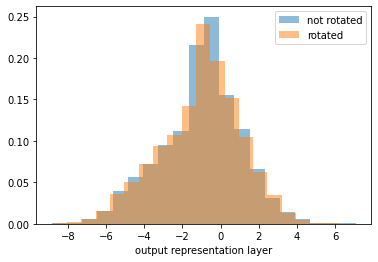

In [ ]:
intermediate_layer_model2 = keras.models.Model(inputs = model5.input, outputs = model5.get_layer("dense_16").output)
intermediate_output = intermediate_layer_model2.predict([rep_layer_test, test_sens])
intermediate_output_rot = intermediate_layer_model2.predict([rep_layer_rot_test, rot_test_sens])

plt.hist(intermediate_output, density = True, alpha=0.5, label='not rotated', bins= 20)
plt.hist(intermediate_output_rot, density = True, alpha=0.5, label='rotated', bins = 20)
plt.xlabel("output representation layer")
plt.legend(loc='best')
plt.savefig("hist_rep1.png")

In [ ]:
## Prepare to plot TSNE for model (baseline)
layer_of_interest=3
intermediate_layer_model = keras.models.Model(inputs=model_new.input,
                                 outputs=model_new.get_layer("dense_2").output)
intermediates = intermediate_layer_model.predict(np.concatenate((x_test, x_test_rot)))
colors = ["blue", "green", "red", "yellow", "orange", "grey", "black", "pink", "purple", "brown"]
color_intermediates = np.array(colors)[np.argmax(np.concatenate((y_test,y_test)), axis=1)]

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(intermediates)

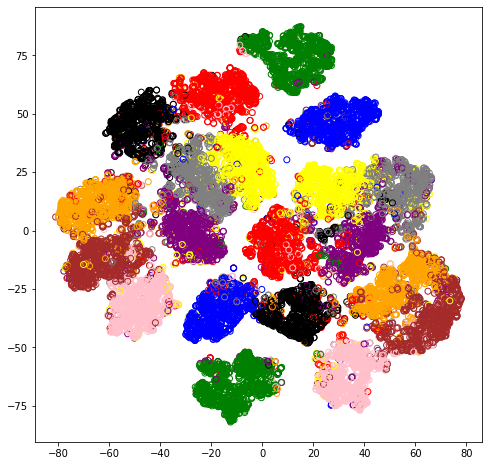

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], facecolors='none', edgecolors=color_intermediates)
plt.show()

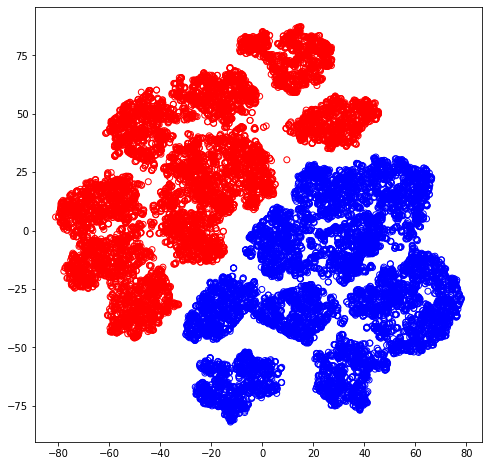

In [ ]:
colors = ["blue", "red"]
labels = np.concatenate((y_test_not_rotated,y_test_rotated)).astype(int)
colors = ["blue", "red"]
color_intermediates = np.array(colors)[labels]
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], facecolors='none', edgecolors=color_intermediates)
plt.show()